In [14]:
import json
import numpy as np
import random
import pandas as pd

from evalplus.eval import (
    PASS,
    compatible_eval_result,
    estimate_pass_at_k,
    untrusted_check,
)


def find_matching_k(results1, results2):
    total_nr_tasks = len(results2["eval"]["HumanEval/0"])
    """Finds the smallest k for which pass@k of results2 matches pass@1 of results1."""
    pass_at_1_results1_base = estimate_pass_at_k(
        np.array([len(r) for r in results1["eval"].values()]),
        np.array([sum([r["base_status"] == PASS for r in res]) for res in results1["eval"].values()]),
        1
    ).mean()

    print(f"Base Pass@1 strong model: {pass_at_1_results1_base:.3f}")

    # compute strong model pass@1 for extra tests
    pass_at_1_results1_plus = estimate_pass_at_k(
        np.array([len(r) for r in results1["eval"].values()]),
        np.array([sum([r["plus_status"] == PASS for r in res]) for res in results1["eval"].values()]),
        1
    ).mean()

    print(f"Plus Pass@1 strong model: {pass_at_1_results1_plus:.3f}")

    pass_at_k_results2 = estimate_pass_at_k(
            np.array([len(r) for r in results2["eval"].values()]),
            np.array([sum([r["base_status"] == PASS for r in res]) for res in results2["eval"].values()]),
            200
        ).mean()
    print(f"Base Pass@200 weak model: {pass_at_k_results2:.3f}")
    
    k = 1
    while True:
        pass_at_k_results2 = estimate_pass_at_k(
            np.array([len(r) for r in results2["eval"].values()]),
            np.array([sum([r["base_status"] == PASS for r in res]) for res in results2["eval"].values()]),
            k
        ).mean()

        if pass_at_k_results2 >= pass_at_1_results1_base:
            return k, pass_at_1_results1_base, pass_at_1_results1_plus
        k += 1
        if k > total_nr_tasks:
            raise ValueError("No matching k found")

def evaluate_results(results, k):
    """Evaluates results based on the specified k."""
    base_success = 0
    plus_success = 0
    total_tasks = 0
    
    for task_results in results["eval"].values():
        total_tasks += 1
        # Select k random solutions
        selected_solutions = random.sample(task_results, min(k, len(task_results)))
        
        # Shuffle selected solutions
        random.shuffle(selected_solutions)
        
        # Find the first passing solution for base tests
        base_pass = False
        for solution in selected_solutions:
            if solution["base_status"] == PASS:
                base_success += 1
                base_pass = True
                break
        
        # Check for plus test success if base test passed
        if base_pass and solution["plus_status"] == PASS:
            plus_success += 1
    
    base_success_rate = base_success / total_tasks
    plus_success_rate = plus_success / total_tasks if base_success > 0 else 0

    return base_success_rate, plus_success_rate, base_success, plus_success, total_tasks

# Load json data
with open("humaneval/chatgpt_temp_0.8/eval_results.json", "r") as f1, open("humaneval/command_cohere_temp_0.8-sanitized/eval_results.json", "r") as f2:
    results1 = json.load(f1)
    results2 = json.load(f2)

# Find matching k
k, pass_at_1_results1_base, pass_at_1_results1_plus = find_matching_k(results1, results2)
print(f"Smallest k with matching pass rate: {k}")

# Evaluate results2 based on matching k
base_success_rate, plus_success_rate, base_success, plus_success, total_tasks = evaluate_results(results2, k)
print(f"Base success rate: {base_success_rate:.3f}")
print(f"Plus success rate: {plus_success_rate:.3f}")
print(f"Base success: {base_success}")
print(f"Plus success: {plus_success}")
print(f"Total tasks: {total_tasks}")

Base Pass@1 strong model: 0.694
Plus Pass@1 strong model: 0.628
Base Pass@200 weak model: 0.701
Smallest k with matching pass rate: 176
Base success rate: 0.701
Plus success rate: 0.549
Base success: 115
Plus success: 90
Total tasks: 164


In [15]:
# Define the strong model results file
results1_files = [
    "humaneval/chatgpt_temp_0.8/eval_results.json",
    "humaneval/gpt-4_temp_0.0/eval_results.json"
]

# Define a list of weak model results files
results2_files = [
    "humaneval/code-llama-7b_temp_0.8/eval_results.json",
    "humaneval/codegen-6b_temp_0.8/eval_results.json",
    "humaneval/code-llama-13b_temp_0.8/eval_results.json",
    "humaneval/vicuna-7b_temp_0.8/eval_results.json",
    "humaneval/mistral-7b_temp_0.8/eval_results.json",
    "humaneval/codegen2-7b_temp_0.8/eval_results.json",
    "humaneval/codet5p-16b_temp_0.8/eval_results.json",
    "humaneval/starcoder_temp_0.8/eval_results.json",
    "humaneval/command_cohere_temp_0.8-sanitized/eval_results.json",
    # "humaneval/chatgpt_temp_0.8/eval_results.json",


]

In [22]:
# Number of sampling repetitions
n_samples = 50

# Create an empty list to store the results
data = []

for results1_file in results1_files:
    # Iterate over weak model results files
    for results2_file in results2_files:
        # Load strong model results
        with open(results1_file, "r") as f1:
            results1 = json.load(f1)

        with open(results2_file, "r") as f2:
            results2 = json.load(f2)

        # Find matching k
        try:
            k, pass_at_1_results1_base, pass_at_1_results1_plus = find_matching_k(results1, results2)
            print(f"Smallest k with matching pass rate: {k}")
        except ValueError as e:
            print(f"Error processing {results2_file}: {e}")
            continue

        # Repeat sampling n times
        base_success_rates = []
        plus_success_rates = []
        for _ in range(n_samples):
            base_success_rate, plus_success_rate, _, _, _ = evaluate_results(results2, k)
            base_success_rates.append(base_success_rate)
            plus_success_rates.append(plus_success_rate)

        # Extract model names from file paths
        model_strong = results1_file.split("/")[1]
        model_weak = results2_file.split("/")[1]

        # Calculate mean and standard deviation for error bars
        mean_base_success_rate = np.mean(base_success_rates)
        std_base_success_rate = np.std(base_success_rates)
        mean_plus_success_rate = np.mean(plus_success_rates)
        std_plus_success_rate = np.std(plus_success_rates)
        sem_base_success_rate = np.std(base_success_rates) / np.sqrt(n_samples)  
        sem_plus_success_rate = np.std(plus_success_rates) / np.sqrt(n_samples) 

        # Append results to the data list
        data.append([model_strong, 
                    model_weak,
                    pass_at_1_results1_base,
                    pass_at_1_results1_plus,
                    k, 
                    mean_base_success_rate, 
                    sem_base_success_rate,
                    mean_plus_success_rate, 
                    sem_plus_success_rate])

# Create a Pandas DataFrame from the results
df = pd.DataFrame(data, columns=[
    "model_strong", 
    "model_weak", 
    "strong_pass@1_base",
    "strong_pass@1_plus",
    "k", 
    "weak_base_success_rate",
    "weak_base_success_rate_sem",
    "weak_plus_success_rate",
    "weak_plus_success_rate_sem",
])

# Print the DataFrame
print(df)

# Save the DataFrame to a CSV file
df.to_csv("evaluation_metrics.csv", index=False)

Base Pass@1 strong model: 0.694
Plus Pass@1 strong model: 0.628
Base Pass@200 weak model: 0.933
Smallest k with matching pass rate: 11
Base Pass@1 strong model: 0.694
Plus Pass@1 strong model: 0.628
Base Pass@200 weak model: 0.817
Smallest k with matching pass rate: 73
Base Pass@1 strong model: 0.694
Plus Pass@1 strong model: 0.628
Base Pass@200 weak model: 0.945
Smallest k with matching pass rate: 6
Base Pass@1 strong model: 0.694
Plus Pass@1 strong model: 0.628
Base Pass@200 weak model: 0.445
Error processing humaneval/vicuna-7b_temp_0.8/eval_results.json: No matching k found
Base Pass@1 strong model: 0.694
Plus Pass@1 strong model: 0.628
Base Pass@200 weak model: 0.890
Smallest k with matching pass rate: 29
Base Pass@1 strong model: 0.694
Plus Pass@1 strong model: 0.628
Base Pass@200 weak model: 0.585
Error processing humaneval/codegen2-7b_temp_0.8/eval_results.json: No matching k found
Base Pass@1 strong model: 0.694
Plus Pass@1 strong model: 0.628
Base Pass@200 weak model: 0.890
S

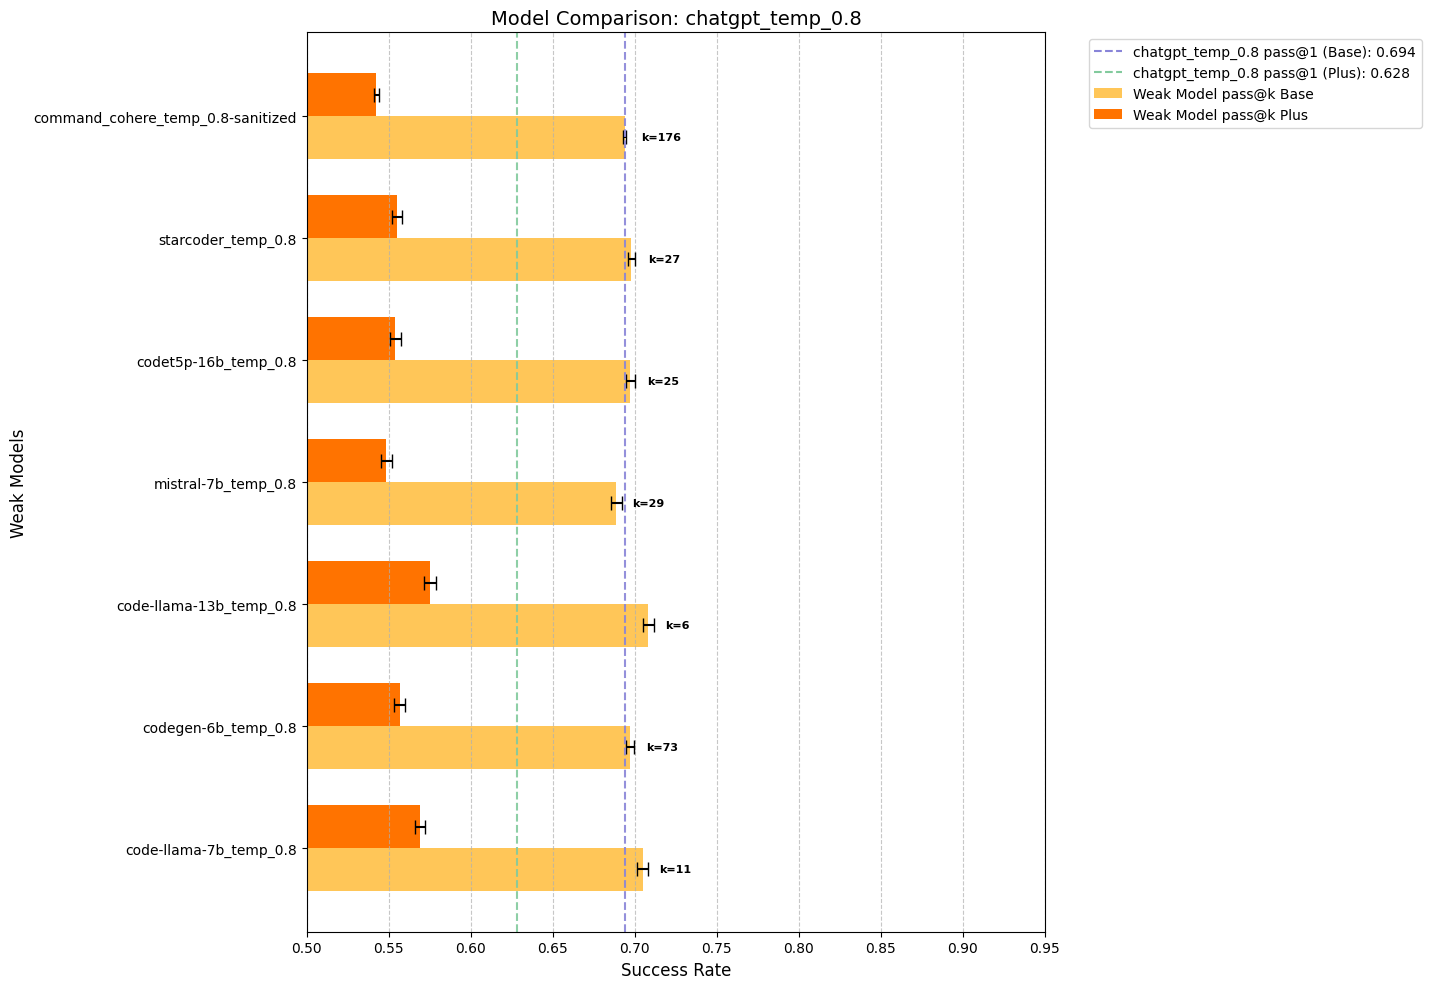

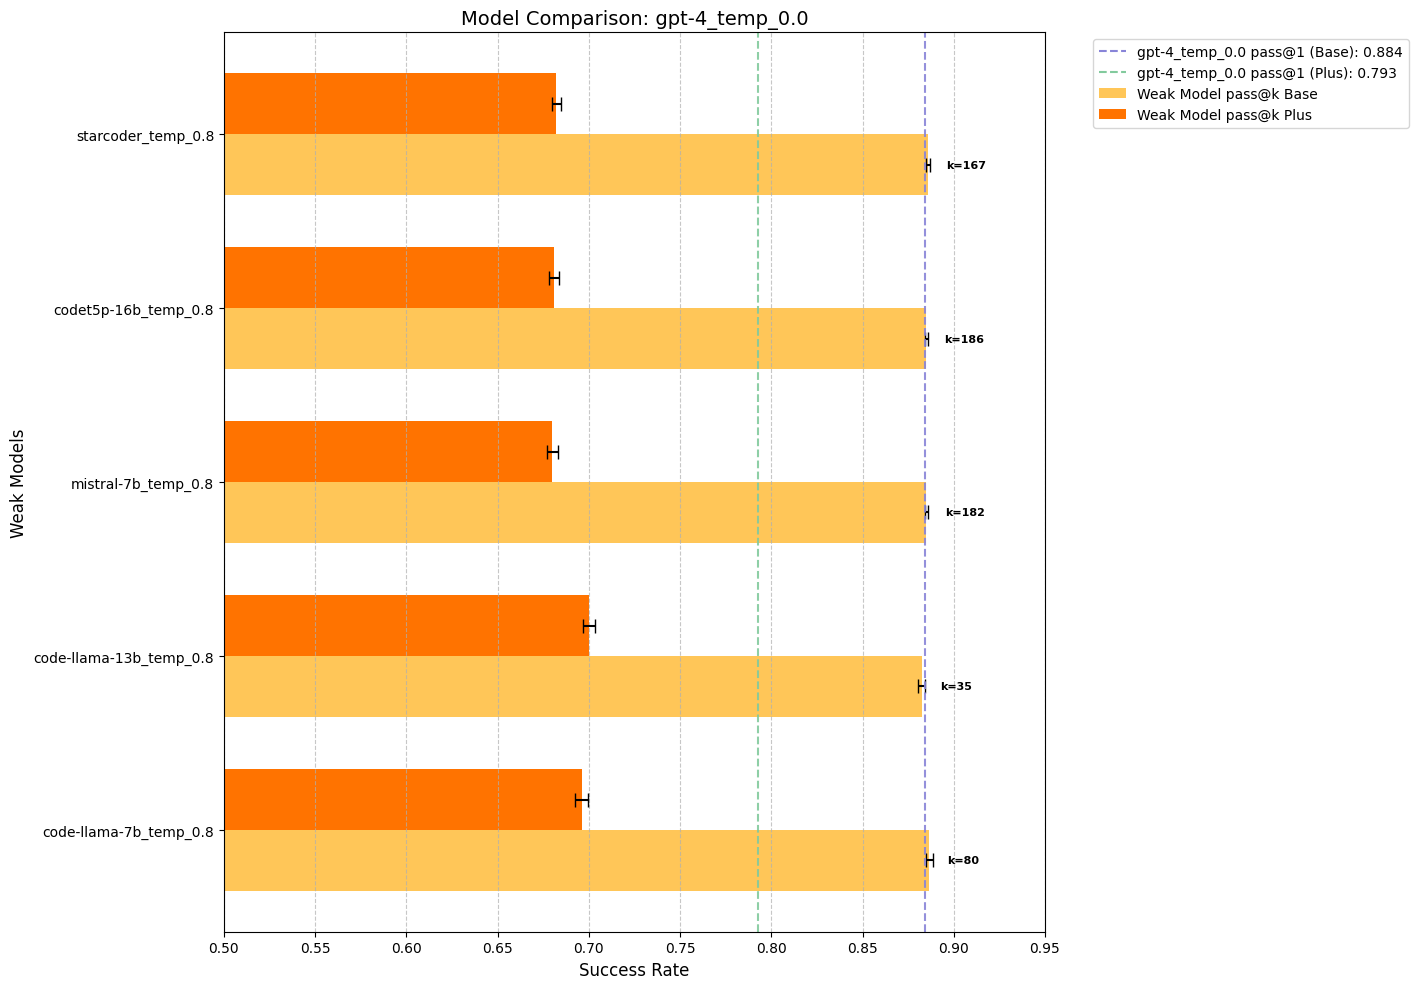

In [56]:
import matplotlib.pyplot as plt

# Get unique strong models
strong_models = df['model_strong'].unique()

# Create a plot for each strong model
for strong_model in strong_models:
    # Filter data for the current strong model
    model_df = df[df['model_strong'] == strong_model]
    
    # Prepare the data
    model_combinations = model_df['model_weak']
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(14, 10))  # Increased figure size to accommodate external legend
    
    # Set the width of each bar and the positions of the bars
    bar_width = 0.35
    r1 = range(len(model_combinations))
    r2 = [x + bar_width for x in r1]
    
    # Create the bars with error bars
    base_bars = ax.barh(r1, model_df['weak_base_success_rate'], xerr=model_df['weak_base_success_rate_sem'], 
            height=bar_width, label='Weak Model pass@k Base', color='#ffc658', capsize=5)
    plus_bars = ax.barh(r2, model_df['weak_plus_success_rate'], xerr=model_df['weak_plus_success_rate_sem'], 
            height=bar_width, label='Weak Model pass@k Plus', color='#ff7300', capsize=5)
    
    # Add k value labels to each bar
    for i, (base_bar, plus_bar) in enumerate(zip(base_bars, plus_bars)):
        k_value = model_df['k'].iloc[i]
        ax.text(base_bar.get_width() + 0.01, base_bar.get_y() + base_bar.get_height()/2, f'k={k_value}', 
                va='center', ha='left', fontsize=8, color='black', fontweight='bold')
    
    # Customize the plot
    ax.set_ylabel('Weak Models', fontsize=12)
    ax.set_xlabel('Success Rate', fontsize=12)
    ax.set_xlim(0.5, 0.95)
    ax.set_title(f'Model Comparison: {strong_model}', fontsize=14)
    ax.set_yticks([r + bar_width/2 for r in range(len(model_combinations))])
    ax.set_yticklabels(model_combinations, fontsize=10)
    
    # Add vertical lines for strong model performance
    strong_base = model_df['strong_pass@1_base'].iloc[0]
    strong_plus = model_df['strong_pass@1_plus'].iloc[0]
    ax.axvline(strong_base, color='#8884d8', linestyle='--', alpha=0.9)
    ax.axvline(strong_plus, color='#82ca9d', linestyle='--', alpha=0.9)
    
    # Add label for strong model performance to legend
    ax.plot([], [], color='#8884d8', linestyle='--', label=f'{strong_model} pass@1 (Base): {strong_base:.3f}')
    ax.plot([], [], color='#82ca9d', linestyle='--', label=f'{strong_model} pass@1 (Plus): {strong_plus:.3f}')
    
    # Add grid lines
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Adjust layout to make room for the legend
    plt.tight_layout()
    
    # Add a legend outside of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    # Adjust the plot to make room for the external legend
    plt.subplots_adjust(right=0.75)
    
    plt.show()

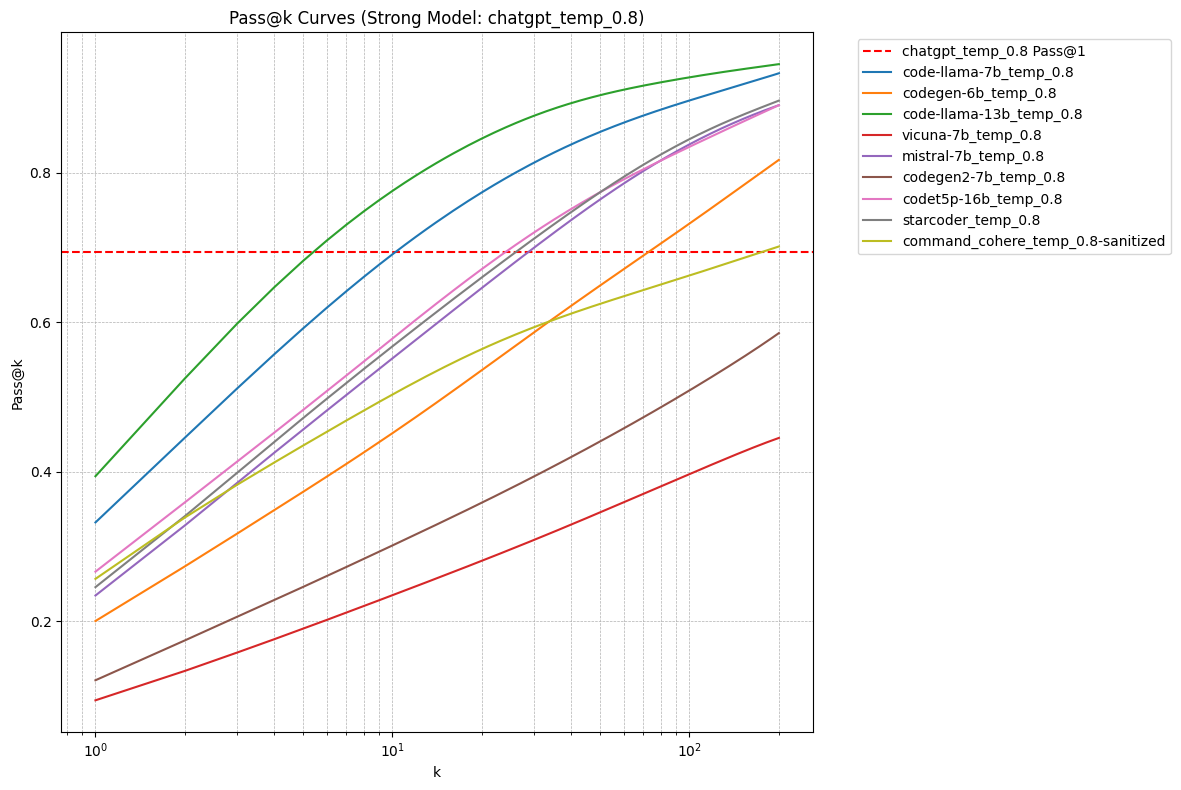

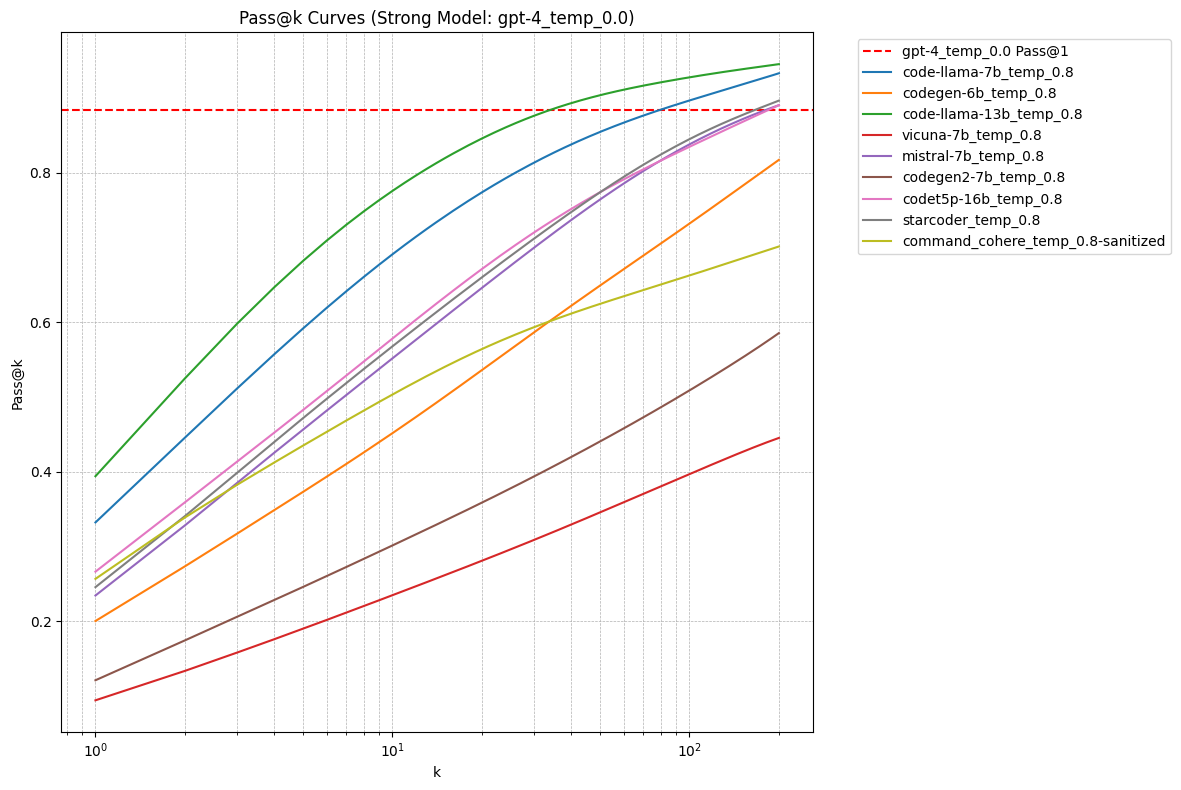

In [49]:
import json
import numpy as np
import matplotlib.pyplot as plt
from evalplus.eval import estimate_pass_at_k, PASS

def load_results(filename):
    with open(filename, "r") as f:
        return json.load(f)

def compute_pass_at_k(results, k_values):
    n_samples = np.array([len(r) for r in results["eval"].values()])
    n_correct = np.array([sum([r["base_status"] == PASS for r in res]) for res in results["eval"].values()])
    return [estimate_pass_at_k(n_samples, n_correct, k).mean() for k in k_values]

def plot_pass_at_k_curves(strong_model_file, weak_model_files):
    # Load strong model results
    strong_results = load_results(strong_model_file)
    strong_model_name = strong_model_file.split('/')[-2]

    # Set up the plot
    plt.figure(figsize=(12, 8))
    
    # Compute and plot strong model pass@1
    strong_pass_at_1 = compute_pass_at_k(strong_results, [1])[0]
    plt.axhline(y=strong_pass_at_1, color='r', linestyle='--', label=f'{strong_model_name} Pass@1')

    # Define k values for the curve
    k_values = list(range(1, 201))  # From 1 to 100

    # Plot weak model curves
    for weak_file in weak_model_files:
        weak_results = load_results(weak_file)
        weak_model_name = weak_file.split('/')[-2]
        pass_at_k_values = compute_pass_at_k(weak_results, k_values)
        plt.plot(k_values, pass_at_k_values, label=weak_model_name)

    # Customize the plot
    plt.xlabel('k')
    plt.ylabel('Pass@k')
    # set x axis to log
    plt.xscale('log')

    plt.title(f'Pass@k Curves (Strong Model: {strong_model_name})')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


# Plot pass@k curves for each strong model
for strong_file in results1_files:
    plot_pass_at_k_curves(strong_file, results2_files)

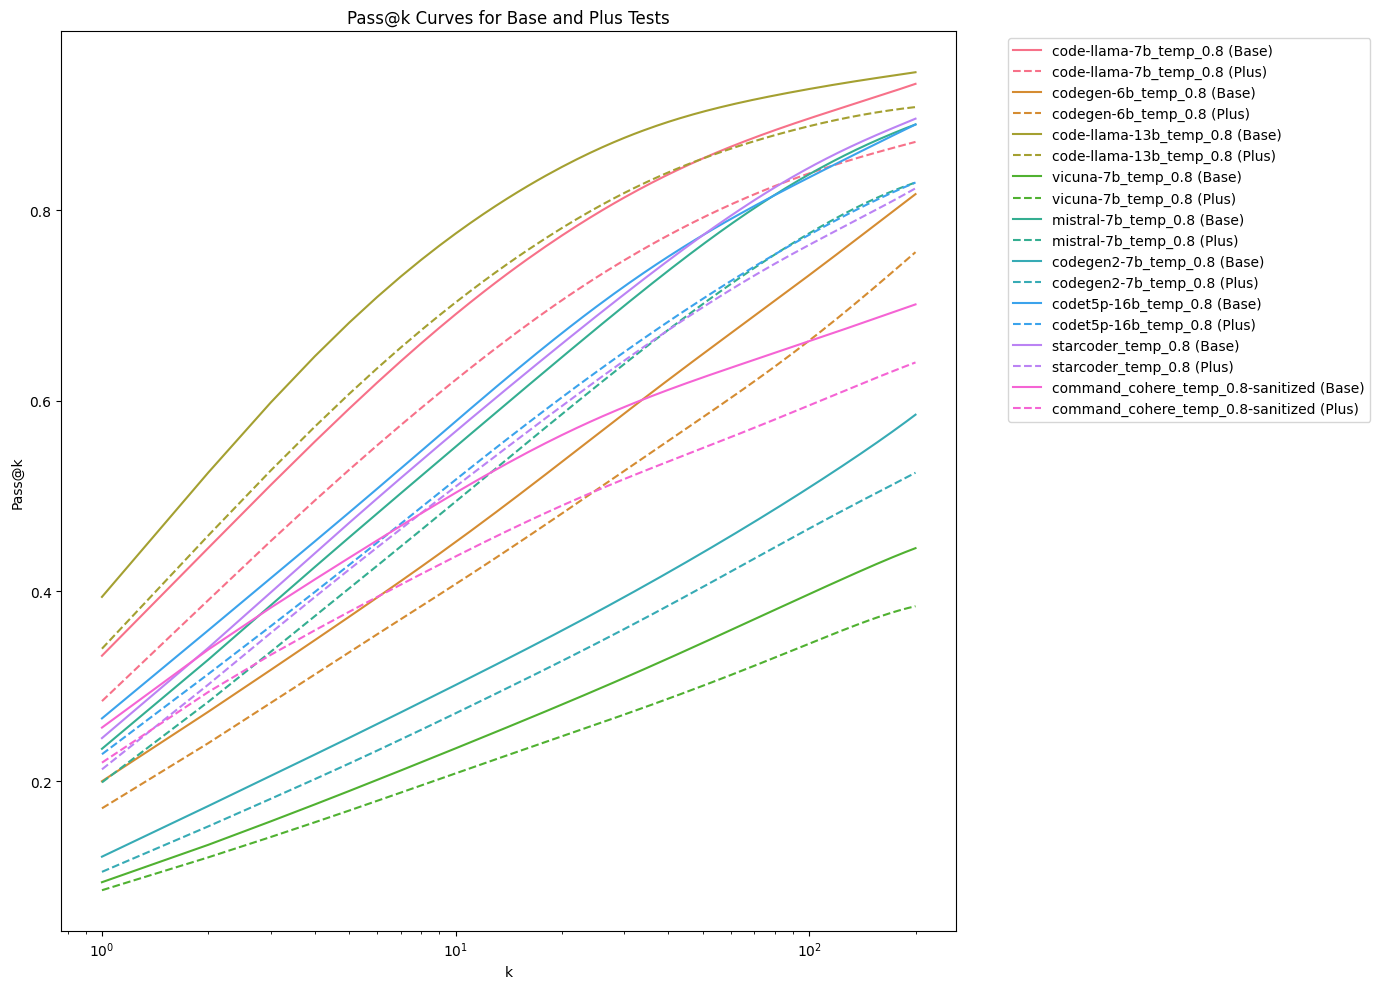

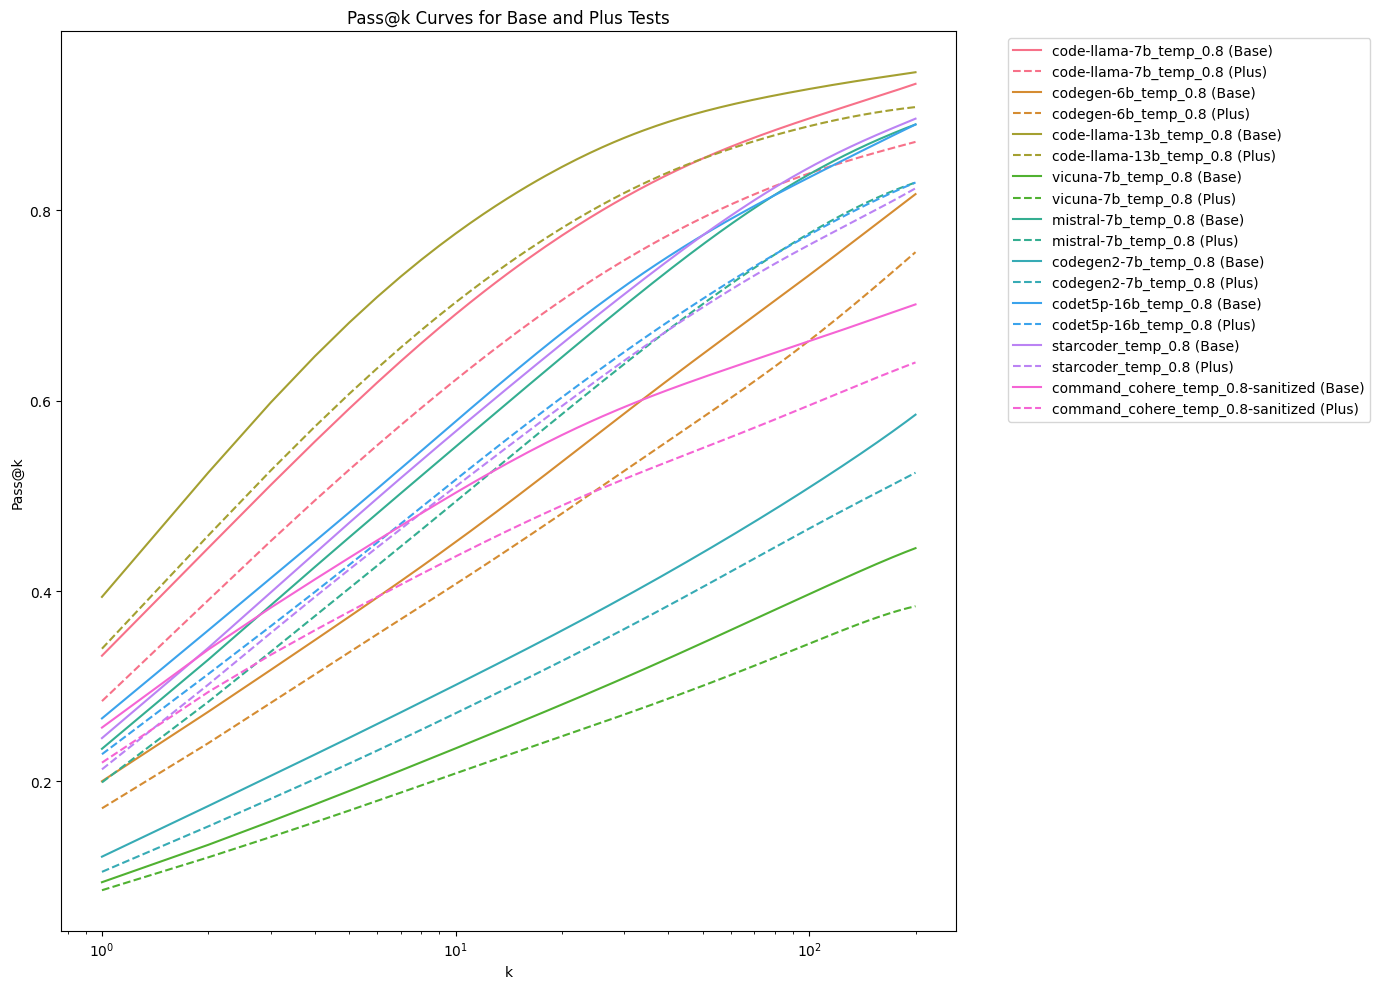

In [57]:
import json
import numpy as np
import matplotlib.pyplot as plt
from evalplus.eval import estimate_pass_at_k, PASS
import seaborn as sns

def load_results(filename):
    with open(filename, "r") as f:
        return json.load(f)

def compute_pass_at_k(results, k_values, test_type='base'):
    n_samples = np.array([len(r) for r in results["eval"].values()])
    if test_type == 'base':
        n_correct = np.array([sum([r["base_status"] == PASS for r in res]) for res in results["eval"].values()])
    else:
        n_correct = np.array([sum([r["plus_status"] == PASS for r in res]) for res in results["eval"].values()])
    return [estimate_pass_at_k(n_samples, n_correct, k).mean() for k in k_values]

def plot_pass_at_k_curves(strong_model_file, weak_model_files):
    # Load strong model results
    strong_results = load_results(strong_model_file)
    strong_model_name = strong_model_file.split('/')[-2]

    # Set up the plot
    plt.figure(figsize=(14, 10))
    
    # Compute and plot strong model pass@1 for base and plus tests
    strong_pass_at_1_base = compute_pass_at_k(strong_results, [1], 'base')[0]
    strong_pass_at_1_plus = compute_pass_at_k(strong_results, [1], 'plus')[0]
    # plt.axhline(y=strong_pass_at_1_base, color='r', linestyle='--', label=f'{strong_model_name} Pass@1 (Base)')
    # plt.axhline(y=strong_pass_at_1_plus, color='r', linestyle=':', label=f'{strong_model_name} Pass@1 (Plus)')

    # Define k values for the curve
    k_values = list(range(1, 201))  # From 1 to 200

    # Generate a color palette
    color_palette = sns.color_palette("husl", len(weak_model_files))

    # Plot weak model curves
    for idx, weak_file in enumerate(weak_model_files):
        weak_results = load_results(weak_file)
        weak_model_name = weak_file.split('/')[-2]
        pass_at_k_values_base = compute_pass_at_k(weak_results, k_values, 'base')
        pass_at_k_values_plus = compute_pass_at_k(weak_results, k_values, 'plus')
        color = color_palette[idx]
        plt.plot(k_values, pass_at_k_values_base, color=color, linestyle='-', label=f'{weak_model_name} (Base)')
        plt.plot(k_values, pass_at_k_values_plus, color=color, linestyle='--', label=f'{weak_model_name} (Plus)')

    # Customize the plot
    plt.xlabel('k')
    plt.ylabel('Pass@k')
    plt.xscale('log')
    plt.title(f'Pass@k Curves for Base and Plus Tests')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
   
    plt.tight_layout()
    plt.show()

# Plot pass@k curves for each strong model
for strong_file in results1_files:
    plot_pass_at_k_curves(strong_file, results2_files)

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Compute false discovery rate
df['weak_fdr'] = (df['weak_base_success_rate'] - df['weak_plus_success_rate']) / df['weak_base_success_rate']

# compute false positive rate
df['weak_fpr'] =  (df['weak_base_success_rate'] - df['weak_plus_success_rate']) / (1 - df['weak_base_success_rate'])


# Function to compute pass@k values (unchanged)
def compute_pass_at_k(n_samples, n_correct, k):
    def estimator(n: int, c: int, k: int) -> float:
        return 1 - np.prod(1 - np.arange(c) / n) if n >= k else 1 - np.prod(1 - c / n)
    
    if isinstance(k, int):
        return np.mean([estimator(n, c, k) for n, c in zip(n_samples, n_correct)])
    return np.mean([estimator(n, c, k) for n, c in zip(n_samples, n_correct) for k in k])

# Compute pass@k values for various k (unchanged)
k_values = [1, 5, 10, 20, 50, 100]
for k in k_values:
    df[f'pass@{k}'] = df.apply(lambda row: compute_pass_at_k(
        np.array([row['k']]), 
        np.array([row['k'] * row['weak_base_success_rate']]), 
        k
    ), axis=1)

print(df[['model_strong', 'model_weak', 'k', 'weak_base_success_rate', 'weak_plus_success_rate', 'weak_fdr']].head())

       model_strong               model_weak   k  weak_base_success_rate  \
0  chatgpt_temp_0.8   code-llama-7b_temp_0.8  11                0.704756   
1  chatgpt_temp_0.8      codegen-6b_temp_0.8  73                0.696951   
2  chatgpt_temp_0.8  code-llama-13b_temp_0.8   6                0.708293   
3  chatgpt_temp_0.8      mistral-7b_temp_0.8  29                0.688537   
4  chatgpt_temp_0.8     codet5p-16b_temp_0.8  25                0.697317   

   weak_plus_success_rate  weak_fdr  
0                0.569024  0.192594  
1                0.556585  0.201400  
2                0.575000  0.188189  
3                0.548537  0.203330  
4                0.554024  0.205491  


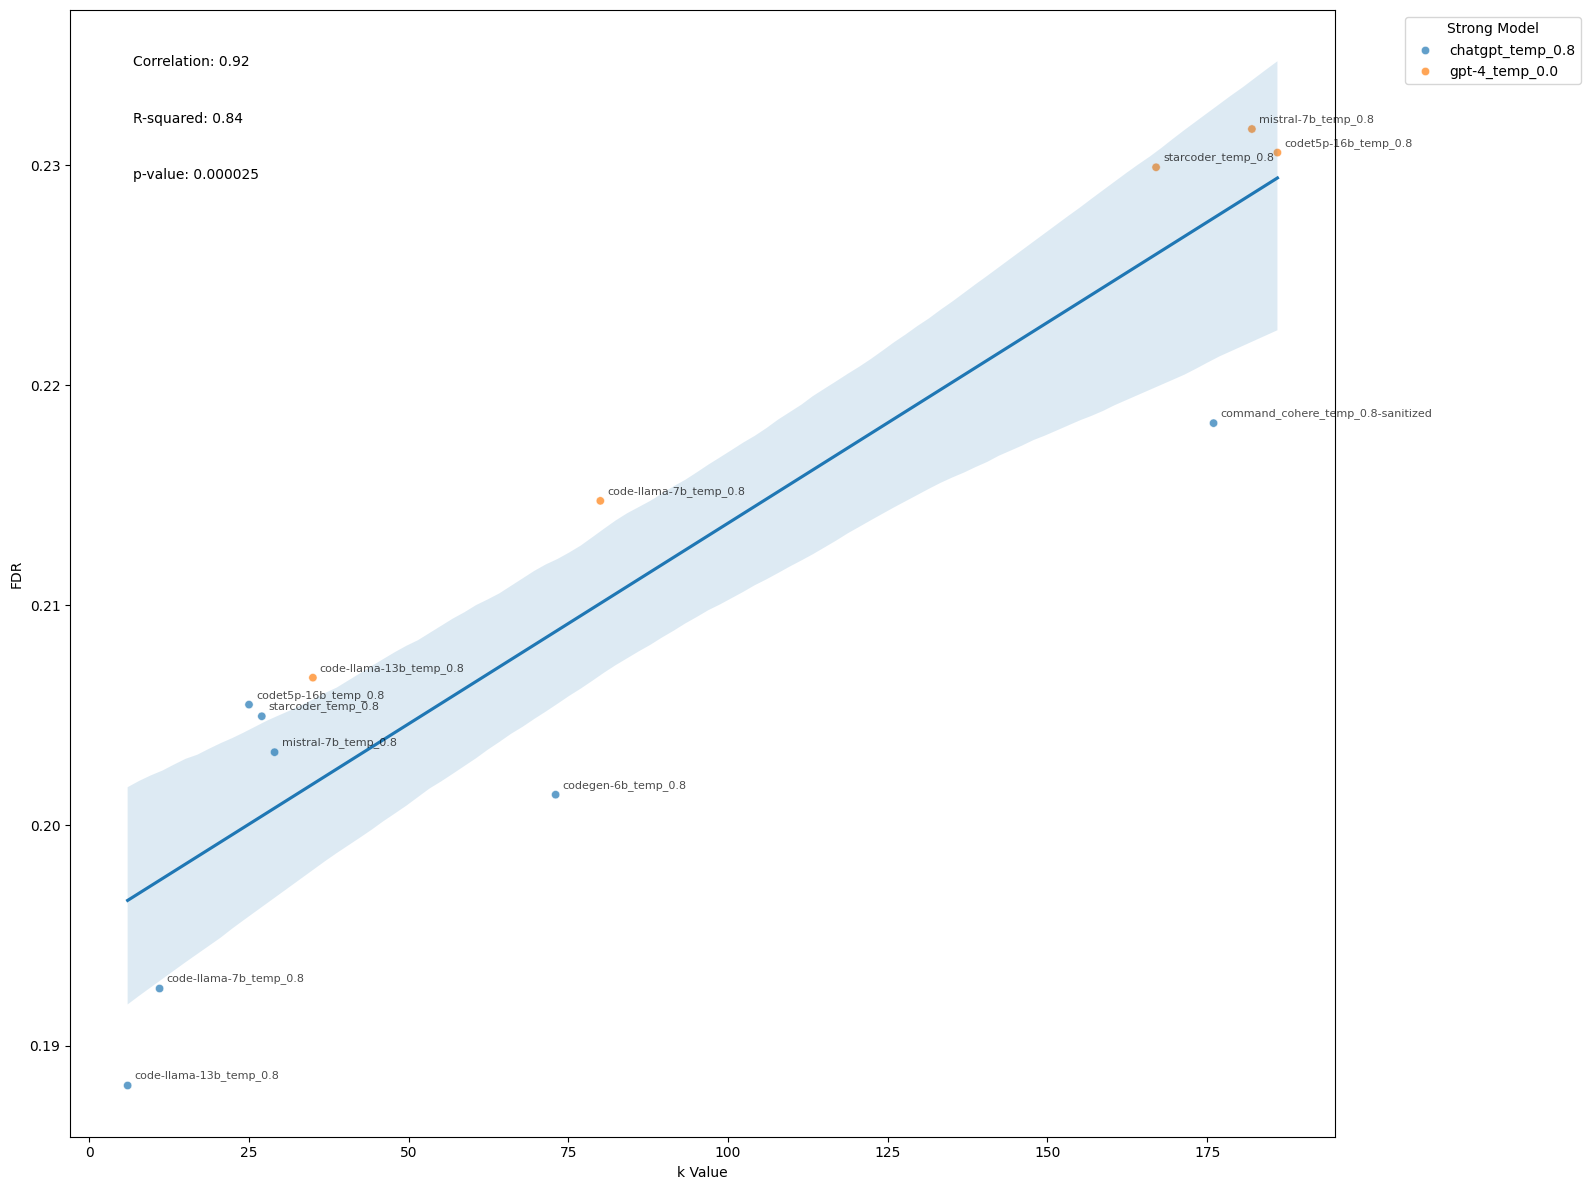

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Create the plot
plt.figure(figsize=(16, 12))  # Increased figure size further to accommodate legend

# Create scatter plot with color coding
scatter = sns.scatterplot(x='k', y='weak_fdr', hue='model_strong', data=df, alpha=0.7)

# Add regression line
sns.regplot(x='k', y='weak_fdr', data=df, scatter=False)

# Calculate correlation coefficient and p-value
corr, p_value_corr = stats.pearsonr(df['k'], df['weak_fdr'])

# Calculate R-squared and other regression statistics
slope, intercept, r_value, p_value_regr, std_err = stats.linregress(df['k'], df['weak_fdr'])
r_squared = r_value**2

# Determine statistical significance
alpha = 0.05  # Significance level
significance = "Significant" if p_value_corr < alpha else "Not significant"

# Add text labels for statistics
plt.text(0.05, 0.95, f'Correlation: {corr:.2f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.90, f'R-squared: {r_squared:.2f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.85, f'p-value: {p_value_corr:.6f}', transform=plt.gca().transAxes)

# Add model names as labels
for _, row in df.iterrows():
    plt.annotate(row['model_weak'], (row['k'], row['weak_fdr']), 
                 xytext=(5, 5), textcoords='offset points', 
                 fontsize=8, alpha=0.7)

plt.xlabel('k Value')
plt.ylabel('FDR')

# Move the legend outside the plot
plt.legend(title='Strong Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent clipping of labels and legend
plt.tight_layout()

plt.show()

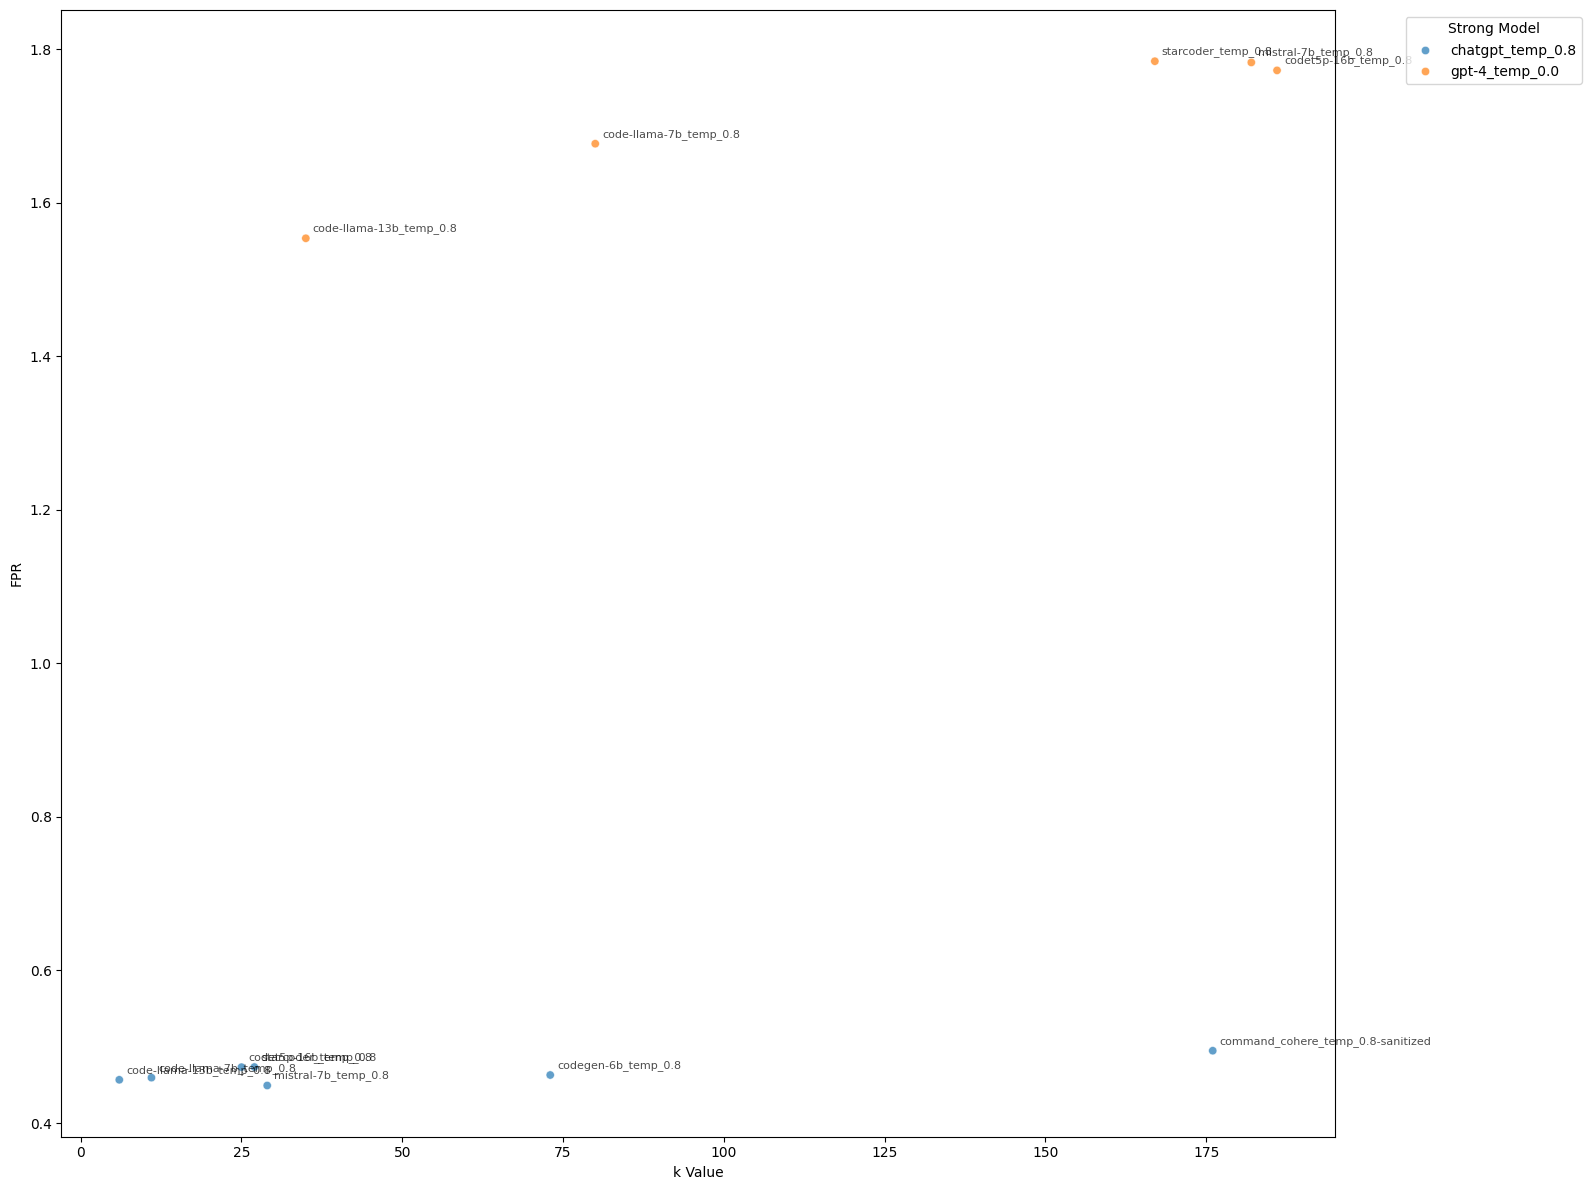

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Create the plot
plt.figure(figsize=(16, 12))  # Increased figure size further to accommodate legend

# Create scatter plot with color coding
scatter = sns.scatterplot(x='k', y='weak_fpr', hue='model_strong', data=df, alpha=0.7)

# Add regression line
# sns.regplot(x='k', y='weak_fpr', data=df, scatter=False)

# Calculate correlation coefficient and p-value
corr, p_value_corr = stats.pearsonr(df['k'], df['weak_fpr'])

# Calculate R-squared and other regression statistics
slope, intercept, r_value, p_value_regr, std_err = stats.linregress(df['k'], df['weak_fpr'])
r_squared = r_value**2

# Determine statistical significance
alpha = 0.05  # Significance level
significance = "Significant" if p_value_corr < alpha else "Not significant"

# Add text labels for statistics
# plt.text(0.05, 0.95, f'Correlation: {corr:.2f}', transform=plt.gca().transAxes)
# plt.text(0.05, 0.90, f'R-squared: {r_squared:.2f}', transform=plt.gca().transAxes)
# plt.text(0.05, 0.85, f'p-value: {p_value_corr:.4f}', transform=plt.gca().transAxes)

# Add model names as labels
for _, row in df.iterrows():
    plt.annotate(row['model_weak'], (row['k'], row['weak_fpr']), 
                 xytext=(5, 5), textcoords='offset points', 
                 fontsize=8, alpha=0.7)

plt.xlabel('k Value')
plt.ylabel('FPR')

# Move the legend outside the plot
plt.legend(title='Strong Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent clipping of labels and legend
plt.tight_layout()

plt.show()